In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.graphics import tsaplots
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [2]:
# get the dataframes we are going to use 

# this is the temperature data
weather = pd.read_csv('C:\\Users\\fderango\\Downloads\\Milestone 1 Dataset\\hr_temp.csv')
#temp.head()
weather.tail()

,STATION,DATE,REPORT_TYPE,SOURCE,HourlyDryBulbTemperature
26275,72520514762,2020-01-31T19:53:00,FM-15,7,34.0
26276,72520514762,2020-01-31T20:53:00,FM-15,7,33.0
26277,72520514762,2020-01-31T21:53:00,FM-15,7,33.0
26278,72520514762,2020-01-31T22:53:00,FM-15,7,33.0
26279,72520514762,2020-01-31T23:53:00,FM-15,7,34.0


In [3]:
# this is the second dataframe to use 
# this is the megawatt data 
energy = pd.read_csv('C:\\Users\\fderango\\Downloads\\Milestone 1 Dataset\\hrl_load.csv')
#load.head()
energy.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,2/1/2017 5:00,2/1/2017 0:00,RFC,WEST,DUQ,DUQ,1419.881,True
1,2/1/2017 6:00,2/1/2017 1:00,RFC,WEST,DUQ,DUQ,1379.505,True
2,2/1/2017 7:00,2/1/2017 2:00,RFC,WEST,DUQ,DUQ,1366.106,True
3,2/1/2017 8:00,2/1/2017 3:00,RFC,WEST,DUQ,DUQ,1364.453,True
4,2/1/2017 9:00,2/1/2017 4:00,RFC,WEST,DUQ,DUQ,1391.265,True


In [4]:
# make a new dataframe from the two dataframes we have 
# make a dictionary first than make the new dataframe  


df = {'Date': weather['DATE'],'mw': energy['mw'], 'Temp': weather['HourlyDryBulbTemperature']}

#this is what we want from both dataframes 
new_df = pd.DataFrame(data=df)
#new_df.head()

In [5]:
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df.dtypes

Date    datetime64[ns]
mw             float64
Temp           float64
dtype: object

In [6]:
new_df['year'] = new_df['Date'].dt.year
new_df['month'] = new_df['Date'].dt.month
new_df['day_of_week'] = new_df['Date'].dt.dayofweek
new_df['hour_of_day'] = new_df['Date'].dt.hour

In [7]:
new_df = new_df.set_index('Date')
new_df

,mw,Temp,year,month,day_of_week,hour_of_day
Date,,,,,,
2017-02-01 00:53:00,1419.881,37.0,2017,2,2,0
2017-02-01 01:53:00,1379.505,37.0,2017,2,2,1
2017-02-01 02:53:00,1366.106,36.0,2017,2,2,2
2017-02-01 03:53:00,1364.453,36.0,2017,2,2,3
2017-02-01 04:53:00,1391.265,36.0,2017,2,2,4
...,...,...,...,...,...,...
2020-01-31 19:53:00,1618.484,34.0,2020,1,4,19
2020-01-31 20:53:00,1580.925,33.0,2020,1,4,20
2020-01-31 21:53:00,1545.354,33.0,2020,1,4,21


In [8]:
new_df['Temp'] = new_df['Temp'].interpolate(method='linear')

In [9]:
train = new_df.loc['2017-02-01': '2019-12-31']
test = new_df.loc['2020-01-01': '2020-01-31']

In [10]:
# question1 build a squared quadratic temp variable 
from sklearn import preprocessing

# First standardize the variable to avoid multicollinearity  
# standardization of dependent variables

# can use either one to standardization 

#Temp_stand = preprocessing.scale(train['Temp'])
train['temp_stand'] = preprocessing.scale(train['Temp'])
# make a quadrtic variable of temp 
train['temp_squared'] = np.square(train['temp_stand'])
train.head()

<ipython-input-10-ba178b3c1e60>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['temp_stand'] = preprocessing.scale(train['Temp'])
<ipython-input-10-ba178b3c1e60>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['temp_squared'] = np.square(train['temp_stand'])


,mw,Temp,year,month,day_of_week,hour_of_day,temp_stand,temp_squared
Date,,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,2017,2,2,0,-0.871516,0.759540
2017-02-01 01:53:00,1379.505,37.0,2017,2,2,1,-0.871516,0.759540
2017-02-01 02:53:00,1366.106,36.0,2017,2,2,2,-0.924513,0.854723
2017-02-01 03:53:00,1364.453,36.0,2017,2,2,3,-0.924513,0.854723
2017-02-01 04:53:00,1391.265,36.0,2017,2,2,4,-0.924513,0.854723


In [11]:
# make a regression model 
# don't need to use temp and also include temp stand in the model 
mod = smf.ols(formula='mw ~ temp_stand + temp_squared + C(month) + C(day_of_week) + C(hour_of_day)', data=train)
res_1 = mod.fit()
print(res_1.summary())
#print(res_1.resid)

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     3180.
Date:                Fri, 01 Oct 2021   Prob (F-statistic):               0.00
Time:                        18:56:36   Log-Likelihood:            -1.5735e+05
No. Observations:               25536   AIC:                         3.148e+05
Df Residuals:                   25493   BIC:                         3.151e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1272.0274 

In [12]:
# this the predictions for the training set using OLS 

train['yhat_ols'] = res_1.predict(train)
train.head()

<ipython-input-12-5f53a7d42c31>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat_ols'] = res_1.predict(train)


,mw,Temp,year,month,day_of_week,hour_of_day,temp_stand,temp_squared,yhat_ols
Date,,,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,2017,2,2,0,-0.871516,0.759540,1313.634130
2017-02-01 01:53:00,1379.505,37.0,2017,2,2,1,-0.871516,0.759540,1283.023332
2017-02-01 02:53:00,1366.106,36.0,2017,2,2,2,-0.924513,0.854723,1276.035116
2017-02-01 03:53:00,1364.453,36.0,2017,2,2,3,-0.924513,0.854723,1283.609276
2017-02-01 04:53:00,1391.265,36.0,2017,2,2,4,-0.924513,0.854723,1324.992443


milestone #4 starts now  

In [13]:
#question #1 save the residuls and make it variable 

# this is the residuls from a perivous model above we created
# you can use the resid function to get the residuls  
# make a new column for training
train['residuals'] = res_1.resid
train['residuals']

<ipython-input-13-b3ecafc33209>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['residuals'] = res_1.resid


Date
2017-02-01 00:53:00    106.246870
2017-02-01 01:53:00     96.481668
2017-02-01 02:53:00     90.070884
2017-02-01 03:53:00     80.843724
2017-02-01 04:53:00     66.272557
                          ...    
2019-12-31 19:53:00    -78.084666
2019-12-31 20:53:00    -87.399614
2019-12-31 21:53:00    -63.024948
2019-12-31 22:53:00    -40.034552
2019-12-31 23:53:00    -15.640103
Name: residuals, Length: 25536, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

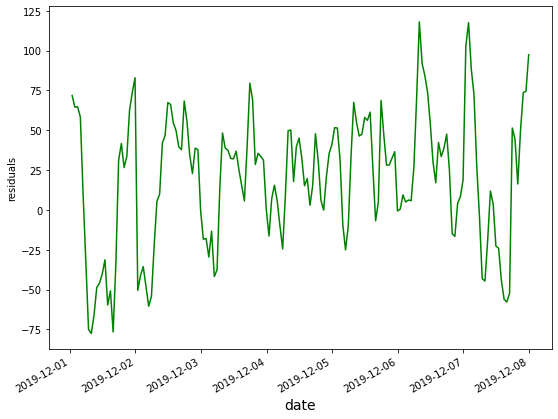

In [14]:
# question #2 plot the residuls over time in the training set 
#train_mw = train['mw']
#week = new_df.loc['2019-12-01':'2019-12-07']

# you can plot both variables togther for one plot. I thought it was two plot but I only needed one line not two.  
train['2019-12-01':'2019-12-07']['residuals'].plot(color='green', figsize=(9,7)) 
plt.xlabel("date", fontsize=14)
plt.ylabel("residuals")
#train_mw['2019-12-01':'2019-12-07'].plot(color='blue', figsize=(9,7))
#plt.legend()
plt.show

 different hours of each day the prediction of energy is worse  

In [15]:
#question #3 exponential smoothing to start us with the time series 

# build a exponential model 
exp = ExponentialSmoothing(train['residuals'],seasonal_periods=24)
res = exp.fit()
print(res.summary())
 


                       ExponentialSmoothing Model Results                       
Dep. Variable:                residuals   No. Observations:                25536
Model:             ExponentialSmoothing   SSE                       34111879.807
Optimized:                         True   AIC                         183794.553
Trend:                             None   BIC                         183810.849
Seasonal:                          None   AICC                        183794.555
Seasonal Periods:                  None   Date:                 Fri, 01 Oct 2021
Box-Cox:                          False   Time:                         18:57:17
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
initial_level              106.246

C:\Anaconda3\envs\Phishing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Anaconda3\envs\Phishing\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [16]:
# get the predicted values of the residuals 
train['yhat_expo'] = res.predict(start='2017-02-01',end='2019-12-31')
train['yhat_expo'].head()

<ipython-input-16-9baeaad9f2c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat_expo'] = res.predict(start='2017-02-01',end='2019-12-31')


Date
2017-02-01 00:53:00    106.246870
2017-02-01 01:53:00    106.246870
2017-02-01 02:53:00     96.530494
2017-02-01 03:53:00     90.103182
2017-02-01 04:53:00     80.890021
Name: yhat_expo, dtype: float64

In [17]:
#this is total predictions for OLS AND EXPONENTIAL 
train['yhat_total'] = train['yhat_expo'] + train['yhat_ols']
train['yhat_total'].head()

<ipython-input-17-3e1abeb1571c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat_total'] = train['yhat_expo'] + train['yhat_ols']


Date
2017-02-01 00:53:00    1419.881000
2017-02-01 01:53:00    1389.270202
2017-02-01 02:53:00    1372.565610
2017-02-01 03:53:00    1373.712458
2017-02-01 04:53:00    1405.882464
Name: yhat_total, dtype: float64

In [18]:
# Calculate the MAPE the new predictions for the training set 

# Get the mape for the model 

# we are measureing the accuarcy of the model 
# and make it a column as well 
train['mape'] = np.abs((train['mw'] - train['yhat_total'])/train['mw'])*100
print('Dynamic model MAPE is:',train['mape'].mean())

Dynamic model MAPE is: 1.7072096133073178


<ipython-input-18-83e5df3b1bce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mape'] = np.abs((train['mw'] - train['yhat_total'])/train['mw'])*100


The Dynamic MAPE decreased to 1.7 where the Naive model was 3.3 

In [19]:
#Forcasting the next 744 hours of residuals which start at january 2020 to the last date  
# need to build the model for test and then i can get the residuals

#need the variables first for scaling 
test['temp_stand'] = preprocessing.scale(test['Temp'])
# make a quadrtic variable of temp 
test['temp_squared'] = np.square(test['temp_stand'])
test.head()




<ipython-input-19-f88b7e2e39dc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['temp_stand'] = preprocessing.scale(test['Temp'])
<ipython-input-19-f88b7e2e39dc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['temp_squared'] = np.square(test['temp_stand'])


,mw,Temp,year,month,day_of_week,hour_of_day,temp_stand,temp_squared
Date,,,,,,,,
2020-01-01 00:53:00,1363.428,31.0,2020,1,2,0,-0.435747,0.189876
2020-01-01 01:53:00,1335.975,29.0,2020,1,2,1,-0.628263,0.394714
2020-01-01 02:53:00,1296.817,30.0,2020,1,2,2,-0.532005,0.283029
2020-01-01 03:53:00,1288.403,30.0,2020,1,2,3,-0.532005,0.283029
2020-01-01 04:53:00,1292.263,31.0,2020,1,2,4,-0.435747,0.189876


In [20]:
# building the ols model with test  
mod_test = smf.ols(formula='mw ~ temp_stand + temp_squared + C(month) + C(day_of_week) + C(hour_of_day)', data=test)
res_ols = mod_test.fit()
print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     223.2
Date:                Fri, 01 Oct 2021   Prob (F-statistic):               0.00
Time:                        18:58:16   Log-Likelihood:                -3962.5
No. Observations:                 744   AIC:                             7989.
Df Residuals:                     712   BIC:                             8137.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1332.6175 

In [21]:
# getting residuals from the model for test  

test['residuals'] = res_ols.resid
test['residuals']

<ipython-input-21-d5b8d27c9f63>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residuals'] = res_ols.resid


Date
2020-01-01 00:53:00     1.252472
2020-01-01 01:53:00   -14.793154
2020-01-01 02:53:00   -27.867199
2020-01-01 03:53:00   -29.432053
2020-01-01 04:53:00   -36.199422
                         ...    
2020-01-31 19:53:00   -44.937207
2020-01-31 20:53:00   -60.261858
2020-01-31 21:53:00   -42.450332
2020-01-31 22:53:00   -31.966072
2020-01-31 23:53:00   -19.793213
Name: residuals, Length: 744, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

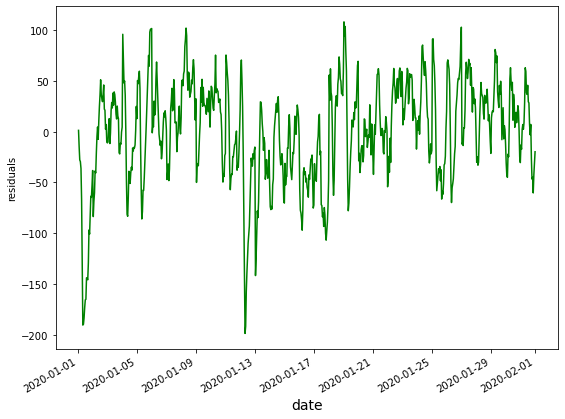

In [22]:
# plot residuals so we can see what we were looking at   

# you can plot both variables togther for one plot. I thought it was two plot but I only needed one line not two.  
test['2020-01-01':'2020-01-31']['residuals'].plot(color='green', figsize=(9,7)) 
plt.xlabel("date", fontsize=14)
plt.ylabel("residuals")
#train_mw['2019-12-01':'2019-12-07'].plot(color='blue', figsize=(9,7))
#plt.legend()
plt.show

In [23]:
# build a exponential model 
exp_test = ExponentialSmoothing(test['residuals'],seasonal_periods=24)
res_2_exp = exp_test.fit()
print(res_2_exp.summary())
 

                       ExponentialSmoothing Model Results                       
Dep. Variable:                residuals   No. Observations:                  744
Model:             ExponentialSmoothing   SSE                         349221.940
Optimized:                         True   AIC                           4580.658
Trend:                             None   BIC                           4589.882
Seasonal:                          None   AICC                          4580.712
Seasonal Periods:                  None   Date:                 Fri, 01 Oct 2021
Box-Cox:                          False   Time:                         18:59:44
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              1.25183

C:\Anaconda3\envs\Phishing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Anaconda3\envs\Phishing\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [24]:
# get the predicted values of the residuals 
test['yhat_expo'] = res_2_exp.predict(start='2020-01-01',end='2020-01-31')
test['yhat_expo'].head()

<ipython-input-24-9aa127150098>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat_expo'] = res_2_exp.predict(start='2020-01-01',end='2020-01-31')


Date
2020-01-01 00:53:00     1.251838
2020-01-01 01:53:00     1.252472
2020-01-01 02:53:00   -14.793154
2020-01-01 03:53:00   -27.867199
2020-01-01 04:53:00   -29.432053
Name: yhat_expo, dtype: float64

In [25]:
#this is total predictions for OLS AND EXPONENTIAL 
# this the predictions for the training set using OLS 

test['yhat_ols'] = res_ols.predict(test)
test.head()




<ipython-input-25-6d8ef0e4b4be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat_ols'] = res_ols.predict(test)


,mw,Temp,year,month,day_of_week,hour_of_day,temp_stand,temp_squared,residuals,yhat_expo,yhat_ols
Date,,,,,,,,,,,
2020-01-01 00:53:00,1363.428,31.0,2020,1,2,0,-0.435747,0.189876,1.252472,1.251838,1362.175528
2020-01-01 01:53:00,1335.975,29.0,2020,1,2,1,-0.628263,0.394714,-14.793154,1.252472,1350.768154
2020-01-01 02:53:00,1296.817,30.0,2020,1,2,2,-0.532005,0.283029,-27.867199,-14.793154,1324.684199
2020-01-01 03:53:00,1288.403,30.0,2020,1,2,3,-0.532005,0.283029,-29.432053,-27.867199,1317.835053
2020-01-01 04:53:00,1292.263,31.0,2020,1,2,4,-0.435747,0.189876,-36.199422,-29.432053,1328.462422


In [26]:
#this is total predictions for test OLS AND EXPONENTIAL
test['yhat_total'] = test['yhat_expo'] + test['yhat_ols']
test['yhat_total'].head()

<ipython-input-26-fe4521d48757>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat_total'] = test['yhat_expo'] + test['yhat_ols']


Date
2020-01-01 00:53:00    1363.427366
2020-01-01 01:53:00    1352.020627
2020-01-01 02:53:00    1309.891045
2020-01-01 03:53:00    1289.967854
2020-01-01 04:53:00    1299.030369
Name: yhat_total, dtype: float64

In [27]:
# Calculate the MAPE the new predictions for the testing set 

# Get the mape for the model 

# we are measureing the accuarcy of the model 
# and make it a column as well 
test['mape'] = np.abs((test['mw'] - test['yhat_total'])/test['mw'])*100
print('expo and ols model MAPE is:',test['mape'].mean())

expo and ols model MAPE is: 1.0751883917850094


<ipython-input-27-e8e41873d9c4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['mape'] = np.abs((test['mw'] - test['yhat_total'])/test['mw'])*100


# Arima model 

In [28]:
# question 4 build a seasonal arima model 

arma = sm.tsa.statespace.SARIMAX(train['residuals'], order=(2,0,0), seasonal_order=(0,1,1,24))
mod_arma = arma.fit()
print(mod_arma.summary())                                 

C:\Anaconda3\envs\Phishing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Anaconda3\envs\Phishing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                      SARIMAX Results                                       
Dep. Variable:                            residuals   No. Observations:                25536
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood             -125445.030
Date:                              Fri, 01 Oct 2021   AIC                         250898.061
Time:                                      19:02:32   BIC                         250930.648
Sample:                                           0   HQIC                        250908.598
                                            - 25536                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0580      0.004    262.684      0.000       1.050       1.066
ar.L2         -0.11

In [29]:
# get the predicted residuals from the training arima model 

# this is just the data from training which doesn't have jan 2020 fyi 
train['yhat_arma'] = mod_arma.predict(start='2017-02-01',end='2019-12-31')
train['yhat_arma'].head()

<ipython-input-29-774f2cfdf820>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat_arma'] = mod_arma.predict(start='2017-02-01',end='2019-12-31')


Date
2017-02-01 00:53:00    0.000000
2017-02-01 01:53:00    1.595906
2017-02-01 02:53:00    2.870764
2017-02-01 03:53:00    3.905138
2017-02-01 04:53:00    4.682616
Name: yhat_arma, dtype: float64

In [30]:
# Add the predictions from the arima model to the energy model predictions 

train['yhat_arma_total'] = train['yhat_arma'] + train['yhat_ols']
train['yhat_arma_total'].head()

<ipython-input-30-80817dde8e29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat_arma_total'] = train['yhat_arma'] + train['yhat_ols']


Date
2017-02-01 00:53:00    1313.634130
2017-02-01 01:53:00    1284.619238
2017-02-01 02:53:00    1278.905880
2017-02-01 03:53:00    1287.514414
2017-02-01 04:53:00    1329.675059
Name: yhat_arma_total, dtype: float64

In [31]:
# Calculate the MAPE the new predictions for the training set for armia 

# Get the mape for the model 

# we are measureing the accuarcy of the model 
# and make it a column as well 
train['mape'] = np.abs((train['mw'] - train['yhat_arma_total'])/train['mw'])*100
print('Arima model MAPE is:',train['mape'].mean())

Arima model MAPE is: 1.483781149639834


<ipython-input-31-1076b12a8253>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mape'] = np.abs((train['mw'] - train['yhat_arma_total'])/train['mw'])*100


Forcast the test set for armia 

In [32]:
# question 4 build a seasonal arima model 

arma = sm.tsa.statespace.SARIMAX(test['residuals'], order=(2,0,0), seasonal_order=(0,1,1,24))
mod_arma = arma.fit()
print(mod_arma.summary()) 

C:\Anaconda3\envs\Phishing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Anaconda3\envs\Phishing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                      SARIMAX Results                                       
Dep. Variable:                            residuals   No. Observations:                  744
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood               -3254.354
Date:                              Fri, 01 Oct 2021   AIC                           6516.708
Time:                                      19:03:34   BIC                           6535.025
Sample:                                           0   HQIC                          6523.779
                                              - 744                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1040      0.032     34.119      0.000       1.041       1.167
ar.L2         -0.22

In [33]:
# forcast the month of january 2020 
# get the predicted values of the residuals 
test['yhat_arma'] = mod_arma.predict(start='2020-01-01',end='2020-01-31')
test['yhat_arma'].head()

<ipython-input-33-ae02ead5c4cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat_arma'] = mod_arma.predict(start='2020-01-01',end='2020-01-31')


Date
2020-01-01 00:53:00    0.000000
2020-01-01 01:53:00    0.005614
2020-01-01 02:53:00   -0.061274
2020-01-01 03:53:00   -0.176378
2020-01-01 04:53:00   -0.280382
Name: yhat_arma, dtype: float64

In [34]:
# Add the predictions from the arima model to the energy model predictions 

test['yhat_arma_total'] = test['yhat_arma'] + test['yhat_ols']
test['yhat_arma_total'].head()

<ipython-input-34-b4cfc1a987af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat_arma_total'] = test['yhat_arma'] + test['yhat_ols']


Date
2020-01-01 00:53:00    1362.175528
2020-01-01 01:53:00    1350.773769
2020-01-01 02:53:00    1324.622925
2020-01-01 03:53:00    1317.658675
2020-01-01 04:53:00    1328.182040
Name: yhat_arma_total, dtype: float64

In [35]:
# Calculate the MAPE the new predictions for the training set for armia 

# Get the mape for the model 

# we are measureing the accuarcy of the model 
# and make it a column as well 
test['mape'] = np.abs((test['mw'] - test['yhat_arma_total'])/test['mw'])*100
print('armia test MAPE is:',test['mape'].mean())

armia test MAPE is: 1.316976709713447


<ipython-input-35-90ae91859eeb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['mape'] = np.abs((test['mw'] - test['yhat_arma_total'])/test['mw'])*100


In [36]:
#Question 5 ensembling multiple forcasts 

train['yhat_average'] = (train['yhat_expo'] + train['yhat_arma'])/2 
train['yhat_average'].head()

<ipython-input-36-b0bc458ab5e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat_average'] = (train['yhat_expo'] + train['yhat_arma'])/2


Date
2017-02-01 00:53:00    53.123435
2017-02-01 01:53:00    53.921388
2017-02-01 02:53:00    49.700629
2017-02-01 03:53:00    47.004160
2017-02-01 04:53:00    42.786319
Name: yhat_average, dtype: float64

In [37]:
# add the average to the dynamic residuls for are new predictions
# get new energy predicts 

train['yhat_new'] = train['yhat_average'] + train['yhat_ols'] 
train['yhat_new'].head()

<ipython-input-37-3911f4ceb123>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat_new'] = train['yhat_average'] + train['yhat_ols']


Date
2017-02-01 00:53:00    1366.757565
2017-02-01 01:53:00    1336.944720
2017-02-01 02:53:00    1325.735745
2017-02-01 03:53:00    1330.613436
2017-02-01 04:53:00    1367.778761
Name: yhat_new, dtype: float64

In [38]:
#Calulate the mape for the new energy predicts   

train['mape'] = np.abs((train['mw'] - train['yhat_new'])/train['mw'])*100
print('new energy MAPE is:',train['mape'].mean())

new energy MAPE is: 1.5270472298588553


<ipython-input-38-2eadfb99cb22>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mape'] = np.abs((train['mw'] - train['yhat_new'])/train['mw'])*100


With the new residuals predictions the mape decreased from 3.3 to 1.5 for the naive. The armia was better with a mape 1.4 and the exponent mape was 1.7 


In [39]:
# Get the forcast for the test set to get predictions

test['yhat_average'] = (test['yhat_expo'] + test['yhat_arma'])/2 
test['yhat_average'].head()

<ipython-input-39-ec1cdea63155>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat_average'] = (test['yhat_expo'] + test['yhat_arma'])/2


Date
2020-01-01 00:53:00     0.625919
2020-01-01 01:53:00     0.629043
2020-01-01 02:53:00    -7.427214
2020-01-01 03:53:00   -14.021788
2020-01-01 04:53:00   -14.856218
Name: yhat_average, dtype: float64

In [40]:
# add the average to the dynamic residuls for are new predictions
# get new energy predicts 

test['yhat_new'] = test['yhat_average'] + test['yhat_ols'] 
test['yhat_new'].head()

<ipython-input-40-c892f3ad6e7b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat_new'] = test['yhat_average'] + test['yhat_ols']


Date
2020-01-01 00:53:00    1362.801447
2020-01-01 01:53:00    1351.397198
2020-01-01 02:53:00    1317.256985
2020-01-01 03:53:00    1303.813265
2020-01-01 04:53:00    1313.606205
Name: yhat_new, dtype: float64

In [41]:
#Calulate the mape for the new energy predicts   

test['mape'] = np.abs((test['mw'] - test['yhat_new'])/test['mw'])*100
print('new energy MAPE is:',test['mape'].mean())

new energy MAPE is: 1.1637875300370337


<ipython-input-41-30e9239bf558>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['mape'] = np.abs((test['mw'] - test['yhat_new'])/test['mw'])*100


The Mape of the ensemble for training is 1.5 and for test is 1.1 